In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-04-28 03:48:54.825605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 03:48:54.825726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 03:48:54.949060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2, rotation_range=5,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, #zoom_range=0.2, 
                                   horizontal_flip=True,vertical_flip=True,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train  = train_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [5]:
valid = valid_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [6]:
test = test_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [7]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
for layer in vgg.layers[:-2]:
    layer.trainable = False

In [9]:
vgg.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_18>

In [10]:
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)
modelVGG16 = Model(inputs=vgg.input, outputs=output)

In [11]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelVGG16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,59

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 28,579,335 (109.02 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [12]:
Metrics=[
      tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
      tf.keras.metrics.AUC(name='auc')
]

In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5.keras')
es = EarlyStopping(verbose=1, patience=20)

In [14]:
modelVGG16.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=Metrics)

In [15]:
history=modelVGG16.fit(train,
                  validation_data=valid,
                  epochs = 5,
                  verbose = 1,
                  callbacks=[lrd,mcp,es]
                 )

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714276245.658563     141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714276245.679887     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


272/359 ━━━━━━━━━━━━━━━━━━━━ 1:20 929ms/step - accuracy: 0.8532 - auc: 0.6619 - loss: 2.0658

W0000 00:00:1714276558.183908     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8555 - auc: 0.6766 - loss: 1.9843

W0000 00:00:1714276635.137038     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714276710.092855     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.8555 - auc: 0.6767 - loss: 1.9835 - val_accuracy: 0.8740 - val_auc: 0.7835 - val_loss: 1.5257 - learning_rate: 0.0010
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 294s 805ms/step - accuracy: 0.8701 - auc: 0.7798 - loss: 1.5537 - val_accuracy: 0.8734 - val_auc: 0.7962 - val_loss: 1.4918 - learning_rate: 0.0010
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 298s 814ms/step - accuracy: 0.8731 - auc: 0.8010 - loss: 1.4866 - val_accuracy: 0.8755 - val_auc: 0.7978 - val_loss: 1.4734 - learning_rate: 0.0010
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 300s 822ms/step - accuracy: 0.8740 - auc: 0.7978 - loss: 1.4886 - val_accuracy: 0.8767 - val_auc: 0.8144 - val_loss: 1.4360 - learning_rate: 0.0010
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 814ms/step - accuracy: 0.8756 - auc: 0.8114 - loss: 1.4538 - val_accuracy: 0.8780 - val_auc: 0.8228 - val_loss: 1.4023 - learning_rate: 0.0010


In [16]:
def Plots(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

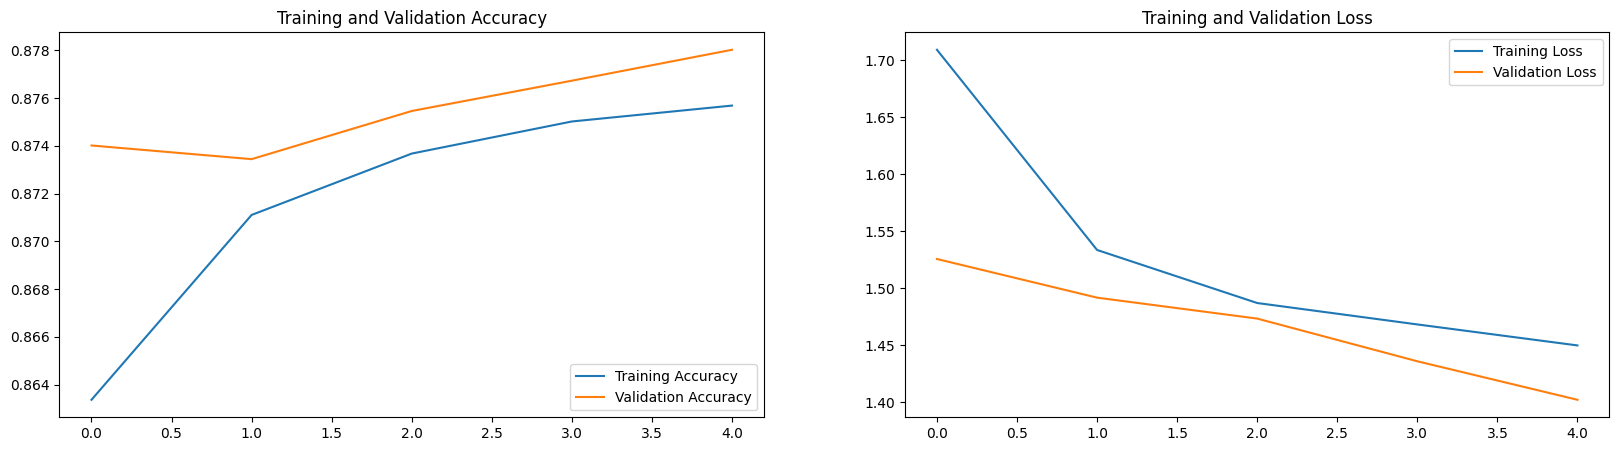

In [17]:
Plots(history)

In [18]:
t_loss, t_accu, t_auc = modelVGG16.evaluate(test)
print("Test accuracy = {:.2f}".format(t_accu*100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 50s 444ms/step - accuracy: 0.8786 - auc: 0.8208 - loss: 1.4153
Test accuracy = 87.90


W0000 00:00:1714277952.618249     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


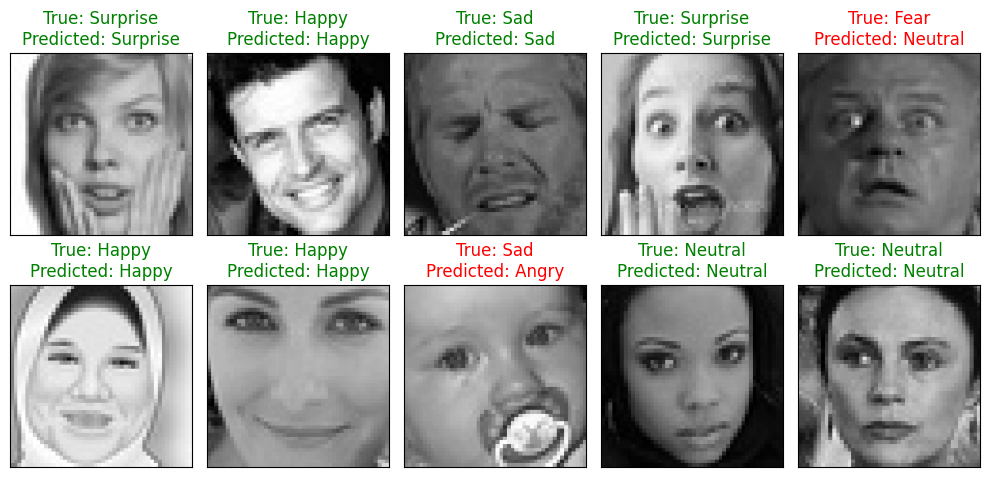

In [21]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(modelVGG16.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [23]:
modelVGG16.save('vgg16.h.keras')